In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.linalg
import scipy.constants as consts

In [5]:
df = pd.read_csv("Lab2.csv")
df['R'] = df.apply(lambda row: row['R'] / 100 ,axis = 1)
df['phi'] = df.apply(lambda row: row['phi'] * 1000,axis = 1)
df['r'] = df.apply(lambda row: row['r'] / 100,axis = 1)
df

,phi,R,U,r
0,2500.0,0.0600,60,0.02
1,2500.0,0.0580,60,0.02
2,2500.0,0.0610,60,0.02
3,5000.0,0.0800,60,0.02
4,5000.0,0.0810,60,0.02
5,5000.0,0.0795,60,0.02
6,7500.0,0.0990,60,0.02
7,7500.0,0.1000,60,0.02
8,7500.0,0.1010,60,0.02
9,10000.0,0.1240,60,0.02


In [9]:
data = df.groupby(['U','r','phi'], as_index = False).mean()
data

,U,r,phi,R
0,60,0.02,2500.0,0.059667
1,60,0.02,5000.0,0.080167
2,60,0.02,7500.0,0.100000
3,60,0.02,10000.0,0.124667
4,60,0.02,12500.0,0.150333


In [10]:
k = 1 / (4 * consts.pi * consts.epsilon_0)
print(k)

8987551787.368177


In [11]:
data['Q'] = data.apply(lambda row: row['phi'] * row['r'] / k,axis = 1)
data

,U,r,phi,R,Q
0,60,0.02,2500.0,0.059667,5.563250e-09
1,60,0.02,5000.0,0.080167,1.112650e-08
2,60,0.02,7500.0,0.100000,1.668975e-08
3,60,0.02,10000.0,0.124667,2.225300e-08
4,60,0.02,12500.0,0.150333,2.781625e-08


In [12]:
data['E'] = data.apply(lambda row: k * row['Q'] / row['R']**2,axis = 1)
data

,U,r,phi,R,Q,E
0,60,0.02,2500.0,0.059667,5.563250e-09,14044.505477
1,60,0.02,5000.0,0.080167,1.112650e-08,15560.098720
2,60,0.02,7500.0,0.100000,1.668975e-08,15000.000000
3,60,0.02,10000.0,0.124667,2.225300e-08,12868.540707
4,60,0.02,12500.0,0.150333,2.781625e-08,11061.892518


In [106]:
Q = data['E'][0] * df['R'][0:3]**2 / k
print(Q)

0    5.625583e-09
1    5.256795e-09
2    5.814665e-09
Name: R, dtype: float64


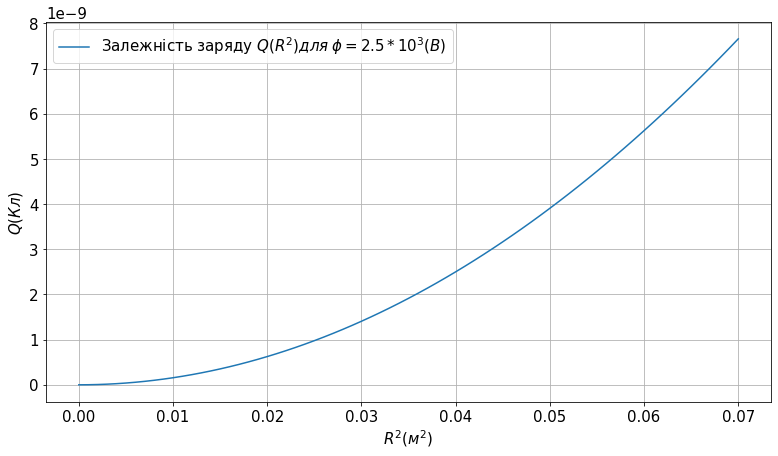

In [118]:
plt.figure(figsize = (13,7))
plt.ylabel("$Q(Кл)$")
plt.rc('font', size=15)
plt.xlabel("$R^2(м^2)$")
plt.grid();


xnew = np.arange(0, np.max(df['R'][0:3]) + 0.01,0.001)
ynew = data['E'][0] * xnew**2 / k

plt.plot(xnew, ynew, '-', label = r"Залежність заряду $Q(R^2) для \;\phi = 2.5(КВ)$")
plt.legend(loc="best");

In [67]:
expData = df[df['phi'] == df['phi'].unique()[0]]
R2Inv = expData.apply(lambda row: 1 / row['R']**2, axis = 1)
E = expData.apply(lambda row: row['phi'] / row['R'], axis = 1)
basis = np.vstack((R2Inv,np.zeros(len(R2Inv)))).T
koef = scipy.linalg.lstsq(basis, E)[0]
print(koef)
print(k * data['Q'][0])

[148.90106318   0.        ]
50.0


$$\Delta R = \sqrt{ R_{шкали}^2 + \frac{\sum_{(R_{i} - \overline R)^2}^{n} }{n} }$$

In [108]:
def std2(array):
    mean = np.ones(len(array)) * array.mean()
    return np.sum(np.power(array - mean, 2)) / len(array)
def partRError(array, partLenght):
    errors = []
    for i in range((int)(len(array) / partLenght)):
        errors.append(std2(array[i*partLenght:(i+1)*partLenght]))
    return errors
print(partRError(df['R'], 3))
deltaR = np.sqrt(0.001**2 * np.ones(len(data['R'])) + partRError(df['R'],3)) # + np.std(data['R'], ddof = 0) / data['R'].count())
eR = deltaR / data['R'] * 100
print(deltaR)
print(eR)

[1.5555555555555585e-06, 3.888888888888896e-07, 6.666666666666586e-07, 2.2222222222222262e-07, 2.2222222222222262e-07]
[0.00159861 0.00117851 0.00129099 0.00110554 0.00110554]
0    2.679235
1    1.470076
2    1.290994
3    0.886798
4    0.735394
Name: R, dtype: float64


$$\Delta Q = \frac{\phi\Delta R}{k}$$

In [109]:
deltaQ = data['phi'] * deltaR / k 
eR = np.divide(deltaQ,data['Q']) * 100
print(deltaQ)
print(eR)

0    4.446735e-10
1    6.556353e-10
2    1.077319e-09
3    1.230081e-09
4    1.537601e-09
Name: phi, dtype: float64
0    7.993053
1    5.892557
2    6.454972
3    5.527708
4    5.527708
dtype: float64


$$\Delta E = \sqrt{(\frac{-2\Delta RkQ}{R^3})^2 + (\frac{k\Delta Q}{R^2})^2}$$

In [110]:
deltaE = np.sqrt((2 * k * data['Q'] / data['R']**3 * deltaR)**2 + (k*deltaQ/data['R']**2)**2)
eE = deltaE / data['E'][1] * 100
print(deltaE)
print(eE)

0    1351.502551
1    1024.685625
2    1042.832681
3     747.053966
4     632.743831
dtype: float64
0    8.685694
1    6.585341
2    6.701967
3    4.801088
4    4.066451
dtype: float64
